In [433]:
from datasets import load_dataset

imagenette = load_dataset(
    'frgfm/imagenette',
    'full_size',
    split='train',
    trust_remote_code=True
)
imagenette

Dataset({
    features: ['image', 'label'],
    num_rows: 9469
})

In [434]:
# Creates custom dataset using star cluster images
from datasets import Dataset, Image, concatenate_datasets
image_paths = []

# Loads 25 class 1 clusters from segmentation software
for i in range(1, 26):  
    image_paths.append({"image": ["..\\data\\raw\\class1\\class1_image_%s.png" % i]})

dataset = Dataset.from_dict({"image": [item["image"][0] for item in image_paths]}).cast_column("image", Image())

# Loads 25 class 2 clusters from segmentation software
for i in range(1, 26):  
    image_paths.append({"image": ["..\\data\\raw\\class2\\class2_image_%s.png" % i]})

dataset = Dataset.from_dict({"image": [item["image"][0] for item in image_paths]}).cast_column("image", Image())

# Loads 25 class 1 clusters from segmentation software
for i in range(1, 26):  
    image_paths.append({"image": ["..\\data\\raw\\class3\\class3_image_%s.png" % i]})


dataset = Dataset.from_dict({"image": [item["image"][0] for item in image_paths]}).cast_column("image", Image())

# Creates labels for each image in dataset for future verification
labels = [1]*25 + [2]*25 + [3]*25 
dataset = dataset.add_column("label", labels)



In [435]:
# Imports CLIP libraries
from transformers import CLIPTokenizerFast, CLIPProcessor, CLIPModel
import torch

# Sets computation device to whatever is available (likely CPU in this case)
device = "cuda" if torch.cuda.is_available() else \
         ("mps" if torch.backends.mps.is_available() else "cpu")

# Specifices version of CLIP to be used from huggingface 
model_id = "openAI/clip-vit-base-patch32"

# Loads the model, tokenizer, and processor
model = CLIPModel.from_pretrained(model_id).to(device)
tokenizer = CLIPTokenizerFast.from_pretrained(model_id)
processor = CLIPProcessor.from_pretrained(model_id)


In [436]:
# Sets input prompt and tokenizes it using tokenizer
prompt = "single dark peak, cicular, symmetric, point source"

inputs = tokenizer(prompt, return_tensors="pt")
inputs

{'input_ids': tensor([[49406,  2688,  3144,  6026,   267, 14539,  4927,   267,  3645, 19950,
           267,  2301,  3634, 49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}

In [437]:
# Embeds the prompt into a vector space in shape suitable for the model
text_emb = model.get_text_features(**inputs)
text_emb.shape

torch.Size([1, 512])

In [438]:
# Processor is used for image and text processing, however this instance is only for images and returns it as a tensor.
image = processor(
    text=None,
    images=dataset[0]['image'], #Custom cluster dataset
    # images=dataset[0]['image'], #Imagenette dataset 
    return_tensors="pt"
)['pixel_values'].to(device)
image.shape

torch.Size([1, 3, 224, 224])

In [439]:
image.squeeze(0).T.shape


torch.Size([224, 224, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7922626..2.145897].


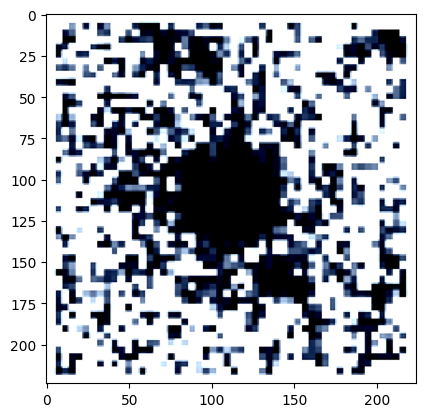

In [440]:
# Displays processed image 
import matplotlib.pyplot as plt

plt.imshow(image.squeeze(0).T)

In [441]:
# Embeds image into vector space, similar to text embedding 
image_emb = model.get_image_features(image)
image_emb.shape

torch.Size([1, 512])

In [442]:
import numpy as np 

# The following code selects a random set of 50 images for testing
np.random.seed(0)
sample_idx = np.random.randint(0, len(dataset), 50).tolist() #custom cluster dataset
images = [dataset[i]['image'] for i in sample_idx] # custom cluster dataset
labels = [dataset[i]['label'] for i in sample_idx]  # custom cluster dataset (assuming labels are in 'label' column)

# sample_idx = np.random.randint(0, len(imagenette), 50).tolist() # imagentte dataset
# images = [imagenette[i]['image'] for i in sample_idx] #imagenette dataset

len(images)


50

In [443]:
from tqdm.auto import tqdm

batch_size = 10 # change depending on size of test set
image_arr = None

for i in tqdm(range(0, len(images), batch_size)):
    # select batch of images
    batch = images[i:i+batch_size]
    # process and resize
    batch = processor(
        text=None,
        images=batch,
        return_tensors='pt',
        padding=True
    )['pixel_values'].to(device)
    # get image embeddings
    batch_emb = model.get_image_features(pixel_values=batch)
    #conver to numpy array
    batch_emb = batch_emb.squeeze(0)
    batch_emb = batch_emb.cpu().detach().numpy()
    #add to larger array of all image embeddings
    if image_arr is None:
        image_arr = batch_emb
    else:
        image_arr = np.concatenate((image_arr, batch_emb), axis=0)
image_arr.shape


  0%|          | 0/5 [00:00<?, ?it/s]

(50, 512)

In [444]:
image_arr.min(), image_arr.max() 

(np.float32(-7.2818174), np.float32(2.7587738))

In [445]:
# Normalizes the image embeddings
image_arr = image_arr.T / np.linalg.norm(image_arr, axis=1)

In [446]:
image_arr = image_arr.T
image_arr.shape
image_arr.min(), image_arr.max()

(np.float32(-0.66778564), np.float32(0.24947001))

In [447]:
text_emb = text_emb.cpu().detach().numpy()

In [448]:
# Takes the dot product of each image and the prompt to determine similarities scores
scores = np.dot(text_emb, image_arr.T)
scores.shape

(1, 50)

In [449]:
# Takes the top 5 image scores and stores them in an index array
top_k = 5
idx = np.argsort(-scores[0])[:top_k]
idx

array([ 5, 17, 30, 26, 38])

In [450]:
'''
class1 = 0
class2 = 0
class3 = 0

for i in range(75):
    index = idx[i]
    if labels[index] == 1:
        class1 = class1+i
    if labels[index] == 2:
        class2 = class2+i
    if labels[index] == 3:
        class3 = class3+i

print(class1/25)
print(class2/25)
print(class3/25)
'''

'\nclass1 = 0\nclass2 = 0\nclass3 = 0\n\nfor i in range(75):\n    index = idx[i]\n    if labels[index] == 1:\n        class1 = class1+i\n    if labels[index] == 2:\n        class2 = class2+i\n    if labels[index] == 3:\n        class3 = class3+i\n\nprint(class1/25)\nprint(class2/25)\nprint(class3/25)\n'

2.7014577


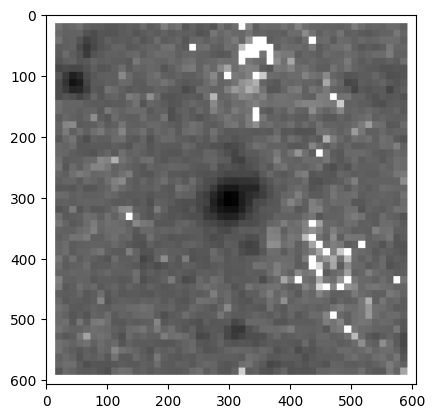

2
2.597684


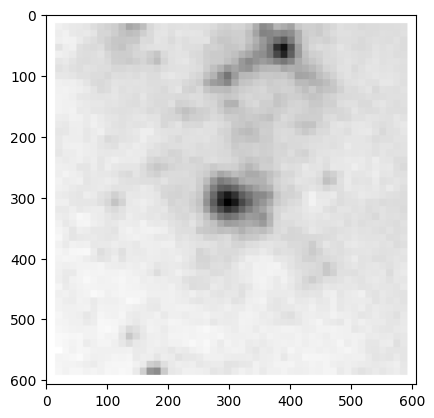

2
2.6396878


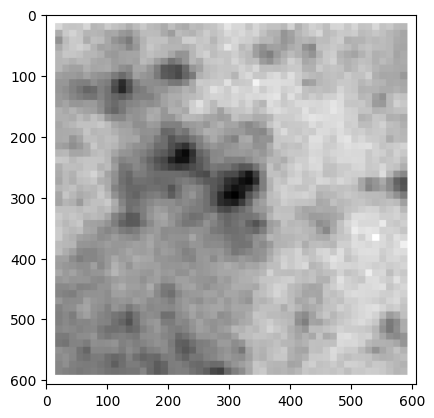

3
2.5720196


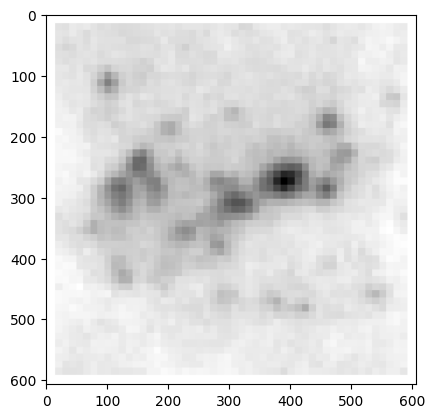

3
2.5720196


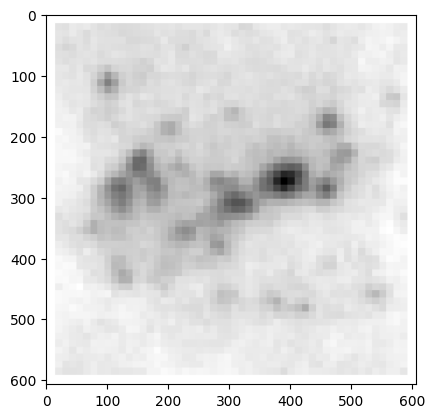

3


In [451]:
# Prints the 5 images with the highest scores

for i in range(5):
    print(scores[0][i])
    plt.imshow(images[i])
    plt.show()
    print(labels[i])